In [1]:
#!pip install transformers

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/21/02/ae8e595f45b6c8edee07913892b3b41f5f5f273962ad98851dc6a564bbb9/transformers-4.31.0-py3-none-any.whl.metadata
  Using cached transformers-4.31.0-py3-none-any.whl.metadata (116 kB)
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/00/45/ec3407adf6f6b5bf867a4462b2b0af27597a26bd3cd6e2534cb6ab029938/filelock-3.12.2-py3-none-any.whl.metadata
  Using cached filelock-3.12.2-py3-none-any.whl.metadata (2.7 kB)
  Obtaining dependency information for huggingface-hub<1.0,>=0.14.1 from https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688bc2d36b3a47d2/huggingface_hub-0.16.4-py3-none-any.whl.metadata
  Using cached huggingface_hub-0.16.4-py3-none-any.whl.metadata (12 kB)
  Obtaining dependency information for regex!=2019.12.17 from https://files.pythonhosted.org/packages/c0/f4/278e305e02245937579a7952b8a3205116b4d2480a3

In [2]:
import copy
from pathlib import Path


import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.metrics import classification_report

from transformers import DistilBertTokenizer

import torch
from torch.utils.data import DataLoader

from arxiv_article_classifier.data.load import load_processed_data
from arxiv_article_classifier.model.distilbertmodel import (MultiLabelDataset, DistilBertClass, seed_everything)

DATAFOLDER = Path().cwd()/'processed_data_distilbert'

## Define Helper Functions

Uncomment below to run on external server (eg to take advantage of GPUs).

In [3]:
#import os
#import random
#import pathlib
#from typing import Tuple
#
#from transformers import DistilBertModel
#from torch.utils.data import Dataset
#
#def load_processed_data(
#    folder: pathlib.Path,
#) -> Tuple[Tuple[np.array, np.array, np.array, np.array, np.array, np.array], np.array]:
#    """Load train, validation and test data and labels from folder."""
#    x_train = np.load(folder / "X_train.npy", allow_pickle=True)
#    x_val = np.load(folder / "X_val.npy", allow_pickle=True)
#    x_test = np.load(folder / "X_test.npy", allow_pickle=True)
#
#    y_train = np.load(folder / "y_train.npy", allow_pickle=True)
#    y_val = np.load(folder / "y_val.npy", allow_pickle=True)
#    y_test = np.load(folder / "y_test.npy", allow_pickle=True)
#
#    labels = np.load(folder / "labels.npy", allow_pickle=True)
#
#    return (x_train, x_val, x_test, y_train, y_val, y_test), labels
#
#
## ------- Seed everything ---------------
#
#def seed_everything(seed):
#    os.environ['PYTHONHASHSEED'] = str(seed)
#    random.seed(seed)
#    np.random.seed(seed)
#    torch.manual_seed(seed)
#    torch.cuda.manual_seed(seed)
#    torch.cuda.manual_seed_all(seed)
#    torch.backends.cudnn.deterministic = True
#    torch.backends.cudnn.benchmark = False
#
#
## ------------ Create DataSet Loader class ---------------
#
#
#class MultiLabelDataset(Dataset):
#    
#    def __init__(self, tokenizer, max_len, X, y=None):
#        self.tokenizer = tokenizer
#        self.max_len = max_len
#        self.X = X
#        self.targets = y
#
#    def __len__(self):
#        return len(self.X)
#    
#    def __getitem__(self, index):
#        text = str(self.X[index])
#        
#        inputs = self.tokenizer.encode_plus(text,
#                                            None,
#                                           add_special_tokens=True,
#                                           truncation=True,
#                                           max_length=self.max_len,
#                                           padding='max_length',
#                                           return_token_type_ids=False
#                                           )
#        out = {
#            "input_ids": torch.tensor(inputs['input_ids'], dtype=torch.long),
#            "attention_mask": torch.tensor(inputs['attention_mask'], dtype=torch.long),
#        }
#
#        if self.targets is not None:
#            out["targets"] = torch.tensor(self.targets[index], dtype=torch.float)
#            
#        return out
#
## -------------- Create Model ------------------
#
#class DistilBertClass(torch.nn.Module):
#    def __init__(self, n_classes):
#        super(DistilBertClass, self).__init__()
#        self.n_classes = n_classes
#        
#        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
#        self.classifier = torch.nn.Sequential(torch.nn.Linear(768, 768),
#                                             torch.nn.ReLU(),
#                                             torch.nn.Dropout(0.1),
#                                             torch.nn.Linear(768, self.n_classes)
#                                             )
#        
#    def forward(self, input_ids, attention_mask):
#        # Since we use DistilBert, no token_type_ids are needed
#        output_1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#        hidden_state = output_1[0]
#        out = hidden_state[:,0]
#        out = self.classifier(out)
#        return out
#
#

## Define and Run DistilBert

In [7]:
# ------ Set Config ----------------

MAX_LEN = 320
EPOCHS = 5
LEARNING_RATE = 1e-05
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
N_WORKERS = 4


# ---- seed everything ------------

seed_everything(42)


# ------ create data loaders ---------

(
    (X_train, X_val, X_test, y_train, y_val, y_test),
    _,
) = load_processed_data(DATAFOLDER)

# define tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

# create datasets
train_set = MultiLabelDataset(tokenizer, MAX_LEN, X_train, y_train)
val_set = MultiLabelDataset(tokenizer, MAX_LEN, X_val, y_val)
test_set = MultiLabelDataset(tokenizer, MAX_LEN, X_test, y_test)

# create dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=N_WORKERS)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=N_WORKERS)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=N_WORKERS)


# -------- create model and move to GPU if available ----------

model = DistilBertClass(n_classes=14)
model.to(DEVICE)
print(f"Model on {DEVICE}")


# ----------- define optimizer and loss function

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.functional.binary_cross_entropy_with_logits # use sigmoid since multilabel cases


# ------------prepare summary lists-----------------
    
loss_train = []
loss_val = []

f1_train = []
f1_val = []

best_f1 = -np.inf


# ------------------- RUN ------------

for epoch in range(EPOCHS):
    print(f"\n==========\nEpoch: {epoch}\n==========\n")
    
    # --------Training--------------
    model.train()
    
    batch_loss = []
    batch_targets = []
    batch_outputs = []
    
    for i, data in enumerate(train_loader):

        # forward pass
        outputs = model(data['input_ids'].to(DEVICE, dtype=torch.long),
                        data['attention_mask'].to(DEVICE, dtype=torch.long))

        # calculate loss
        targets = data['targets'].to(DEVICE, dtype=torch.float)
        loss = loss_fn(outputs, targets)
        
        batch_loss.append(loss.item())  
        batch_targets.extend(targets.cpu().detach().numpy().tolist())

        # use sigmoid function for scoring
        batch_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        # backward pass   
        loss.backward()

        # update weights
        optimizer.step()
        
        # zero gradients
        optimizer.zero_grad()
        
    # calculate epoch loss
    loss_train_epoch = sum(batch_loss)/len(batch_loss)
    loss_train.append(loss_train_epoch)
    
    # calculate epoch f1
    batch_predictions = np.array(batch_outputs) >= 0.5
    f1_train_epoch = metrics.f1_score(batch_targets,
                                      batch_predictions,
                                      average='weighted')
    f1_train.append(f1_train_epoch)
    
    # -------- Validation -----------------
    # set model to eval mode and run through eval set
    model.eval()
    
    batch_loss = []
    batch_targets = []
    batch_outputs = []

    with torch.inference_mode():
        for _, data in enumerate(val_loader, 0):
          outputs = model(data['input_ids'].to(DEVICE, dtype=torch.long),
                          data['attention_mask'].to(DEVICE, dtype=torch.long))   
          targets = data['targets'].to(DEVICE, dtype=torch.float)
            
          batch_loss.append(loss_fn(outputs, targets).item())
          batch_targets.extend(targets.cpu().detach().numpy().tolist())

          # use sigmoid function for scoring
          batch_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    
    # calculate epoch loss
    loss_val_epoch = sum(batch_loss)/len(batch_loss)
    loss_val.append(loss_val_epoch)
    
    # calculate epoch f1
    batch_predictions = np.array(batch_outputs) >= 0.5
    f1_val_epoch = metrics.f1_score(batch_targets,
                                    batch_predictions,
                                    average='weighted')
    f1_val.append(f1_val_epoch)

    # --------- Generate Report -------------------
    # print report
    print(f"Loss (train): {loss_train_epoch}")
    print(f"Loss (val): {loss_val_epoch}")
    print(f"F1-weighted (train): {f1_train_epoch}")
    print(f"F1-weighted (val): {f1_val_epoch}")
        
    # keep track of best weights
    print("-----")
    if f1_val_epoch > best_f1:
        print(f"f1-score increased from {best_f1} to {f1_val_epoch}")
        print("Updating best weights")
        best_f1 = f1_val_epoch
        best_weights = copy.deepcopy(model.state_dict())
    else:
        print("F1 score did not improve")

    
# Restore best weights
model.load_state_dict(best_weights)

Model on cuda:0

Epoch: 0

Loss (train): 0.27910732977124614
Loss (val): 0.16974471788853407
F1-weighted (train): 0.23796981132108608
F1-weighted (val): 0.6040927334728584
-----
f1-score increased from -inf to 0.6040927334728584
Updating best weights

Epoch: 1

Loss (train): 0.14837484179245236
Loss (val): 0.1355803556226451
F1-weighted (train): 0.6913897544387837
F1-weighted (val): 0.7196389602373238
-----
f1-score increased from 0.6040927334728584 to 0.7196389602373238
Updating best weights

Epoch: 2

Loss (train): 0.12372307447034613
Loss (val): 0.1289181979694243
F1-weighted (train): 0.7501055407758155
F1-weighted (val): 0.7209071862187241
-----
f1-score increased from 0.7196389602373238 to 0.7209071862187241
Updating best weights

Epoch: 3

Loss (train): 0.11010467833616971
Loss (val): 0.1265498786715084
F1-weighted (train): 0.7796676910308483
F1-weighted (val): 0.7359027477924049
-----
f1-score increased from 0.7209071862187241 to 0.7359027477924049
Updating best weights

Epoch: 

<All keys matched successfully>

In [9]:

# ------------------- RUN ------------
EPOCHS = 5

for epoch in range(EPOCHS):
    print(f"\n==========\nEpoch: {epoch}\n==========\n")
    
    # --------Training--------------
    model.train()
    
    batch_loss = []
    batch_targets = []
    batch_outputs = []
    
    for i, data in enumerate(train_loader):

        # forward pass
        outputs = model(data['input_ids'].to(DEVICE, dtype=torch.long),
                        data['attention_mask'].to(DEVICE, dtype=torch.long))

        # calculate loss
        targets = data['targets'].to(DEVICE, dtype=torch.float)
        loss = loss_fn(outputs, targets)
        
        batch_loss.append(loss.item())  
        batch_targets.extend(targets.cpu().detach().numpy().tolist())

        # use sigmoid function for scoring
        batch_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        # backward pass   
        loss.backward()

        # update weights
        optimizer.step()
        
        # zero gradients
        optimizer.zero_grad()
        
    # calculate epoch loss
    loss_train_epoch = sum(batch_loss)/len(batch_loss)
    loss_train.append(loss_train_epoch)
    
    # calculate epoch f1
    batch_predictions = np.array(batch_outputs) >= 0.5
    f1_train_epoch = metrics.f1_score(batch_targets,
                                      batch_predictions,
                                      average='weighted')
    f1_train.append(f1_train_epoch)
    
    # -------- Validation -----------------
    # set model to eval mode and run through eval set
    model.eval()
    
    batch_loss = []
    batch_targets = []
    batch_outputs = []

    with torch.inference_mode():
        for _, data in enumerate(val_loader, 0):
          outputs = model(data['input_ids'].to(DEVICE, dtype=torch.long),
                          data['attention_mask'].to(DEVICE, dtype=torch.long))   
          targets = data['targets'].to(DEVICE, dtype=torch.float)
            
          batch_loss.append(loss_fn(outputs, targets).item())
          batch_targets.extend(targets.cpu().detach().numpy().tolist())

          # use sigmoid function for scoring
          batch_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    
    # calculate epoch loss
    loss_val_epoch = sum(batch_loss)/len(batch_loss)
    loss_val.append(loss_val_epoch)
    
    # calculate epoch f1
    batch_predictions = np.array(batch_outputs) >= 0.5
    f1_val_epoch = metrics.f1_score(batch_targets,
                                    batch_predictions,
                                    average='weighted')
    f1_val.append(f1_val_epoch)

    # --------- Generate Report -------------------
    # print report
    print(f"Loss (train): {loss_train_epoch}")
    print(f"Loss (val): {loss_val_epoch}")
    print(f"F1-weighted (train): {f1_train_epoch}")
    print(f"F1-weighted (val): {f1_val_epoch}")
        
    # keep track of best weights
    print("-----")
    if f1_val_epoch > best_f1:
        print(f"f1-score increased from {best_f1} to {f1_val_epoch}")
        print("Updating best weights")
        best_f1 = f1_val_epoch
        best_weights = copy.deepcopy(model.state_dict())
    else:
        print("F1 score did not improve")

    
# Restore best weights
model.load_state_dict(best_weights)


Epoch: 0

Loss (train): 0.09009335735103846
Loss (val): 0.12752662664921632
F1-weighted (train): 0.8262067321137381
F1-weighted (val): 0.7486620205310004
-----
f1-score increased from 0.7468496223034957 to 0.7486620205310004
Updating best weights

Epoch: 1

Loss (train): 0.08101480619715022
Loss (val): 0.13307129260923328
F1-weighted (train): 0.847439776813512
F1-weighted (val): 0.7415699520366549
-----
F1 score did not improve

Epoch: 2

Loss (train): 0.07170157828914102
Loss (val): 0.1387680472067461
F1-weighted (train): 0.8682836892419422
F1-weighted (val): 0.7485905463694602
-----
F1 score did not improve

Epoch: 3

Loss (train): 0.06285637454028671
Loss (val): 0.14356248689301568
F1-weighted (train): 0.8869253742785534
F1-weighted (val): 0.7444038015392997
-----
F1 score did not improve

Epoch: 4

Loss (train): 0.05445499214924624
Loss (val): 0.15004497287987634
F1-weighted (train): 0.9046922874347714
F1-weighted (val): 0.7424316484746257
-----
F1 score did not improve


<All keys matched successfully>

## Plot loss and performance metric

In order to decide the best number of training epochs, we plot the loss and the performance metric for train and validation data as function the number of epoch. 

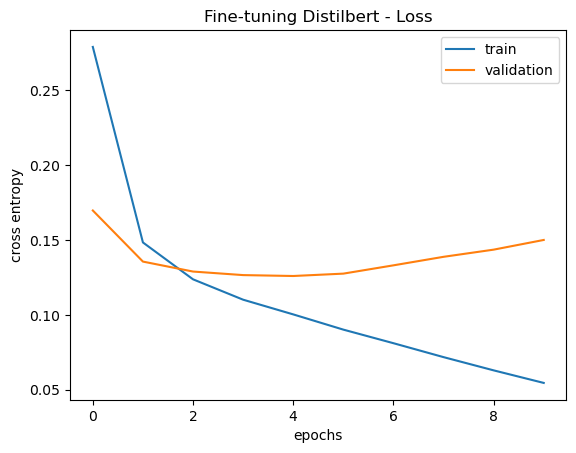

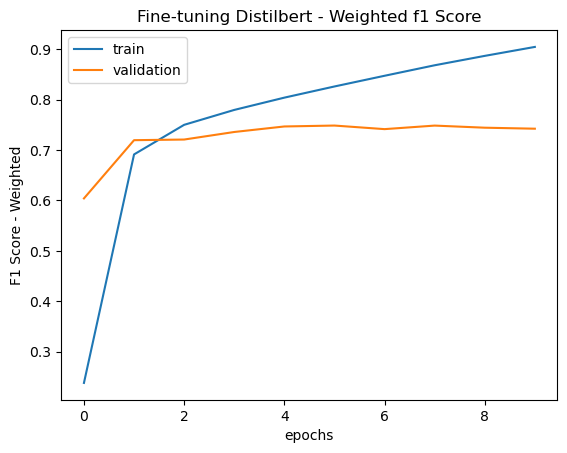

In [10]:
# ----------- Plot the loss and accuracy --------
plt.plot(loss_train, label="train")
plt.plot(loss_val, label="validation")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.title("Fine-tuning Distilbert - Loss")
plt.legend()
plt.savefig('distilbert-cross-entropy-against-epochs.png')
plt.show()

plt.plot(f1_train, label="train")
plt.plot(f1_val, label="validation")
plt.xlabel("epochs")
plt.ylabel("F1 Score - Weighted")
plt.title("Fine-tuning Distilbert - Weighted f1 Score")
plt.savefig('distilbert-f1-against-epochs.png')
plt.legend()
plt.show()

We see that validation loss starts plateauing after 1 to 2 epochs and the validation f1-score plateaus around a similar number of epochs with a minimum at 5 epochs. From the figure above, I would choose 5 epochs of training.

However, no need to retrain since we have already saved the best weights and can directly use them for scoring.

Let's first produce the report on the validation data set.

In [11]:
# -------- Validation -----------------
# set model to eval mode and run through eval set
model.eval()

fin_targets = []
fin_outputs = []

with torch.inference_mode():
    for _, data in enumerate(val_loader, 0):
      outputs = model(data['input_ids'].to(DEVICE, dtype=torch.long),
                      data['attention_mask'].to(DEVICE, dtype=torch.long)
                    )

      # use sigmoid function for scoring
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      targets = data['targets'].to(DEVICE, dtype=torch.float)
      fin_targets.extend(targets.cpu().detach().numpy().tolist())

fin_outputs = np.array(fin_outputs) >= 0.5

print(classification_report(fin_targets, fin_outputs))

              precision    recall  f1-score   support

           0       0.86      0.77      0.82       839
           1       0.85      0.79      0.82       823
           2       0.73      0.64      0.68       642
           3       0.85      0.77      0.81       609
           4       0.71      0.60      0.65      1996
           5       0.76      0.59      0.66       600
           6       0.83      0.82      0.82       720
           7       0.82      0.77      0.79       610
           8       0.95      0.94      0.95       601
           9       0.77      0.77      0.77       633
          10       0.69      0.50      0.58       701
          11       0.89      0.78      0.83       611
          12       0.76      0.60      0.67       715
          13       0.86      0.80      0.83       602

   micro avg       0.80      0.71      0.75     10702
   macro avg       0.81      0.72      0.76     10702
weighted avg       0.80      0.71      0.75     10702
 samples avg       0.81   

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Nice! A weighted f1-score of 0.75. A bit better even though not a lot better than our TFIDF + logistic regression approach. Note that we did not do any rebalancing of data here, something that we saw had a good effect in the tfidf model. This could be addressed by adapting the loss-function to take into account weights.

## Final Scoring

Now that we have a final model, we can perform a final scoring on the held out test set to get an estimate how good this model would perform in deployment.

In [12]:
# -------- Final Test Set Evaluation -----------------
# set model to eval mode and run through eval set
model.eval()

fin_targets = []
fin_outputs = []

with torch.inference_mode():
    for _, data in enumerate(test_loader, 0):
      outputs = model(data['input_ids'].to(DEVICE, dtype=torch.long),
                      data['attention_mask'].to(DEVICE, dtype=torch.long))

      # use sigmoid function for scoring
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    
      targets = data['targets'].to(DEVICE, dtype=torch.float)
      fin_targets.extend(targets.cpu().detach().numpy().tolist())

fin_outputs = np.array(fin_outputs) >= 0.5

print(classification_report(fin_targets, fin_outputs))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       839
           1       0.84      0.79      0.81       824
           2       0.76      0.67      0.71       642
           3       0.89      0.76      0.82       610
           4       0.72      0.61      0.66      1995
           5       0.78      0.56      0.66       600
           6       0.83      0.85      0.84       720
           7       0.84      0.73      0.78       611
           8       0.95      0.96      0.96       600
           9       0.78      0.76      0.77       634
          10       0.71      0.51      0.60       701
          11       0.88      0.75      0.81       610
          12       0.75      0.59      0.66       716
          13       0.86      0.82      0.84       601

   micro avg       0.81      0.71      0.76     10703
   macro avg       0.82      0.72      0.77     10703
weighted avg       0.80      0.71      0.75     10703
 samples avg       0.82   

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Nice! A weighted f1-score of 0.75, in line with the performance on the validation set. This means that we have not overfitted on the validation set and should be able to expect a similar performance in deployment.